# X-ray Propagation Simulation Notebook

This notebook simulates the propagation of an X-ray field through an object mask, computes its FFT, runs multiple random-phase realizations, rebins the detector intensity to match a 13 µm pixel size, and finally computes ensemble-averaged quantities and correlations (including a normalized g² function).

In [47]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import json
from scipy.signal import fftconvolve
from scipy.ndimage import gaussian_filter
from scipy.ndimage import map_coordinates


# Set default figure size for consistency
plt.rcParams['figure.figsize'] = (8, 6)

# Functions for the focal spot pattern

In [48]:
def create_slit_mask(X, Y):
    """
    Create a simple slit mask: light is transmitted (1) only when |x| < slit_width/2.
    """
    mask = np.ones_like(X)
    slit_width = 1e-5  # Slit width
    mask[np.abs(X) > slit_width/2] = 0
    return mask

def create_gaussian_mask(X, Y, w=20e-6):
    """
    Create a Gaussian amplitude mask with a specified 1/e² intensity diameter.
    The amplitude falls to 1/e at a radius of (diameter/2).
    """

    mask = np.sqrt(np.exp(- 2*(X**2 + Y**2) / (w*w)))
    return mask

def create_slit_pattern(X, Y, period=1e-6, duty_cycle=0.5, angle=0):
    """
    Create a binary slit pattern with a given period, duty cycle, and rotation angle.
    """
    xp = X * np.cos(angle) + Y * np.sin(angle)
    mod_val = np.mod(xp, period)
    pattern = np.where(mod_val < duty_cycle * period, 1, 0)
    return pattern

def create_slit_pattern_rand(X, Y, period=0.5e-6, duty_cycle=0.5, angle=0):
    """
    Create a binary slit pattern with a given period, duty cycle, and rotation angle.
    Introduces a random phase shift between 0 and 1 period to simulate sampling different parts of the periodic pattern.
    
    Parameters:
      X, Y      : 2D coordinate grids (meters).
      period    : Period of the slits (meters).
      duty_cycle: Fraction of each period that is open (transparent).
      angle     : Rotation angle (radians) of the slit pattern.
    
    Returns:
      pattern   : 2D binary array with values 1 (open) and 0 (blocked).
    """
    # Compute rotated coordinate system
    xp = X * np.cos(angle) + Y * np.sin(angle)
    
    # Generate a **random phase shift** between 0 and 1 full period
    shift_amount = np.random.uniform(0, 2*period)  
    xp_shifted = xp + shift_amount  # Apply random shift
    
    # Create the slit pattern with the randomly shifted coordinate
    mod_val = np.mod(xp_shifted, period)
    pattern = np.where(mod_val < duty_cycle * period, 1, 0)
    
    return pattern


def create_slit_pattern_rand_smooth(X, Y, period=4e-6, duty_cycle=0.3, angle=0, smoothing_fraction=0.1, dx_source=1e-6):
    """
    Create a slit pattern with soft edges using a Gaussian blur, where the blur width is a fraction of the period.

    Parameters:
      X, Y               : 2D coordinate grids (meters).
      period             : Period of the slits (meters).
      duty_cycle         : Fraction of each period that is open (transparent).
      angle              : Rotation angle (degrees) of the slit pattern.
      smoothing_fraction : Fraction of the period over which smoothing occurs (e.g., 0.1 for 10%).
      dx_source          : Grid spacing (pixel size in meters).

    Returns:
      pattern_smooth     : 2D **smoothed** array (values between 0 and 1).
    """
    import numpy as np
    from scipy.ndimage import gaussian_filter
    
    # Compute rotated coordinate system
    angle = np.deg2rad(angle)
    xp = X * np.cos(angle) + Y * np.sin(angle)
    
    # Generate a **random phase shift** between 0 and 1 full period
    shift_amount = np.random.uniform(0, period)  
    xp_shifted = xp + shift_amount  # Apply random shift
    
    # Create binary slit pattern
    mod_val = np.mod(xp_shifted, period)
    pattern_hard = np.where(mod_val < duty_cycle * period, 1, 0)
    
    # Define blur width as a fraction of the period
    blur_width = smoothing_fraction * period  # Defines blur in meters
    
    # Convert to pixels
    blur_sigma = blur_width / dx_source  # Converts to pixels
    
    # Apply Gaussian blur for smooth edges
    pattern_smooth = gaussian_filter(pattern_hard.astype(float), sigma=blur_sigma)
    pattern_smooth = np.clip(pattern_smooth, 0, 1)  # Clip values to [0, 1] to avoid numerical phase shifts
    
    return pattern_smooth


def create_double_gaussian_mask(X, Y, sigma=30e-6, separation=0.5e-3, angle=0):
    """
    Create a mask consisting of two Gaussian spots.
    
    Each spot is a 2D Gaussian with an RMS width 'sigma'.
    The centers of the spots are located along a line at the specified 'angle'
    (in radians) with respect to the horizontal X-axis. The spots are separated
    by 'separation' (center-to-center).
    
    Parameters:
      X, Y       : 2D coordinate grids (in meters).
      sigma      : RMS width (standard deviation) of each Gaussian spot (in meters).
                   Default is 30 µm.
      separation : Center-to-center separation between the two spots (in meters).
                   Default is 0.5 mm.
      angle      : Rotation angle (in radians) of the line joining the centers.
                   Default is 0 (horizontal alignment).
    
    Returns:
      mask       : 2D array where each pixel value is the sum of the amplitudes
                   of the two Gaussian spots.
    """
    # Convert angle from degrees to radians.
    angle = np.deg2rad(angle)
    
    # Calculate half the separation projected onto x and y based on the angle.
    dx = (separation / 2) * np.cos(angle)
    dy = (separation / 2) * np.sin(angle)
    
    # Define centers of the two spots.
    # When angle=0, centers are at (-separation/2, 0) and (separation/2, 0)
    center1_x, center1_y = -dx, -dy
    center2_x, center2_y =  dx,  dy
    
    # Create the two Gaussian spots.
    spot1 = np.exp(-(((X - center1_x)**2 + (Y - center1_y)**2) / (2 * sigma**2)))
    spot2 = np.exp(-(((X - center2_x)**2 + (Y - center2_y)**2) / (2 * sigma**2)))
    
    # Sum the two spots to form the final mask.
    mask = spot1 + spot2
    return mask

# Propagation function

The function chooses Fraunhoffer or Fresnel propagation depending on the Fresnel number.

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def combined_propagation(E, wavelength, z, dx, threshold=1.0, padding_factor=2):
    """
    Propagate the field E over distance z using either Fraunhofer or Fresnel propagation,
    depending on the computed Fresnel number.
    """
    N = E.shape[0]
    aperture_size = dx * N
    Fresnel_number = aperture_size**2 / (wavelength * z)
    
    if Fresnel_number < threshold:
        E_out = fraunhofer_propagation(E, wavelength, z, dx, padding_factor=padding_factor)  # Unpack and discard x_det, y_det
        return E_out
    else:
        E_out = fresnel_propagation(E, wavelength, z, dx, padding_factor=padding_factor)  # Unpack and discard x_out, y_out
        return E_out
    
    
def fraunhofer_propagation(E, wavelength, z, dx, padding_factor=2):
    """
    Propagate an input field E using the Fraunhofer approximation with zero-padding.
    """
    N = E.shape[0]

    # Zero-padding the input field
    pad_width = N * (padding_factor-1)//2

    padded_E = np.pad(E, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
    padded_N = padded_E.shape[0]

    fx = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    FX, FY = np.meshgrid(fx, fy)

    # Fourier transform of the padded input field
    input_spectrum = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_E)))

    # Coordinates in the observation plane
    x_det = fx * wavelength * z
    y_det = x_det.copy()
    X_det = FX * wavelength * z
    Y_det = FY * wavelength * z

    k = 2 * np.pi / wavelength

    # Calculate the output field using the Fraunhofer approximation
    output_field = np.exp(1j * k * z) * np.exp(-1j * k / (2 * z) * (X_det**2 + Y_det**2)) * input_spectrum
    output_field = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(output_field)))

    return output_field[pad_width:pad_width+N,pad_width:pad_width+N], x_det, y_det


def fresnel_propagation(E, wavelength, z, dx, padding_factor=2):
    """
    Propagate an input field E using the Fresnel approximation.
    """
    N = E.shape[0]

    pad_width = N * (padding_factor-1)//2

    padded_E = np.pad(E, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
    padded_N = padded_E.shape[0]

    fx = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(padded_N, d=dx))
    FX, FY = np.meshgrid(fx, fy)

    x_det = fx*wavelength*z
    y_det = fy*wavelength*z

    k = 2 * np.pi / wavelength

    H = np.exp(-1j*k*z)*np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))

    input_spectrum = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_E)))

    output_spectrum = input_spectrum * H
    output_field = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(output_spectrum)))

    return output_field[pad_width:pad_width+N, pad_width:pad_width+N]

# Detection including Poisson statistics (low photon number)

In [50]:
# -----------------------------------------------------------------------------
# Rebin the simulation images to match the detector's pixel sizes 
# (typically 13µm for CCDs, 55µm for Minipix)
# -----------------------------------------------------------------------------

def rebin_2d(a, bin_factor):
    nrows = (a.shape[0] // bin_factor) * bin_factor
    ncols = (a.shape[1] // bin_factor) * bin_factor
    a_cropped = a[:nrows, :ncols]
    new_shape = (nrows // bin_factor, bin_factor, ncols // bin_factor, bin_factor)
    return a_cropped.reshape(new_shape).mean(axis=(1, 3))

def CCD_detection_binned(intensity, bin_factor, gain=10, QE=0.57, ADC_bits=18):
    """
    Simulate CCD detection by combining binning and photon statistics.
    
    Parameters:
      intensity : 2D array of continuous simulated intensity (e.g., |E|^2).
      bin_factor: Integer number of simulation pixels to combine into one CCD pixel.
      gain      : Gain factor (default: 1).
      QE        : Quantum efficiency (default: 0.57, i.e. 57%).
      ADC_bits  : ADC resolution in bits (default: 10 bits, so max value = 2^10).
      
    Returns:
      detected  : 2D array of simulated CCD counts (integers) after binning and Poisson noise.
    """
    # First, rebin the high-resolution intensity image to the detector pixel scale.
    binned_intensity = rebin_2d(intensity, bin_factor)
    
    # Now, simulate photon detection using Poisson noise.
    # Here the binned intensity is assumed to represent the mean number of photons per CCD pixel.
    detected = np.random.poisson(binned_intensity) * gain * QE
    
    # Clip values that exceed the ADC maximum
    max_value = 2 ** ADC_bits
    detected[detected > max_value] = max_value
    
    # Round to nearest integer (simulate ADC digitization)
    detected = np.round(detected).astype(int)
    
    return detected

# Full simulation functions

In [51]:
# ----------------------------------------------------------------------------
# Function 1: Simulation of intensity images (binned) for a multi-shot experiment
# Run this function to simulate intensity images for num_shots shots.
# ----------------------------------------------------------------------------
def simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                              gauss_width, stripe_period,
                              current_object_mask_func,
                              num_pixels, dx_source, angle, wavelength,
                              bin_factor, gain, QE, ADC_bits):
    """
    Simulate intensity images from a multi-shot experiment.
    
    Parameters:
      X_source, Y_source: 2D coordinate grids in the source plane (m)
      num_shots: number of shots (different grating masks)
      num_modes_per_shot: number of modes per shot (random phase realizations)
      I0: source intensity (photons per pixel at source)
      z_prop: propagation distance (m)
      gauss_width: diameter (or width) of the Gaussian aperture (m)
      stripe_period: period of the grating (m)
      current_object_mask_func: function to generate a grating mask;
          Called as: current_object_mask_func(X, Y, period, duty_cycle, angle, smoothing_fraction, dx_source)
      num_pixels: simulation grid size (assumed square)
      dx_source: pixel size in the source plane (m)
      angle: angle for the grating mask (radians)
      wavelength: wavelength (m)
      bin_factor: binning factor to convert simulation resolution to detector resolution
      gain, QE, ADC_bits: parameters for CCD_detection_binned.
      
    Returns:
      intensity_images: list of binned intensity images (one per shot)
      field_images: list of the last propagated field from each shot (optional)
    """   
    intensity_images = []
    field_images = []
    
    # Create the Gaussian mask using the provided gauss_width.
    gaussian_mask = create_gaussian_mask(X_source, Y_source, gauss_width)
    
    for shot in range(num_shots):
        # Generate a grating mask (one per shot) using the provided stripe_period.
        grating_mask = current_object_mask_func(X_source, Y_source, period=stripe_period,
                                                duty_cycle=0.7, angle=angle, smoothing_fraction=0.1, dx_source=dx_source)
        # Combine with the Gaussian mask to form the overall object mask.
        current_object_mask = gaussian_mask * grating_mask
        
        # Compute intensity per mode.
        intensity_per_mode = I0 * np.ones((num_pixels, num_pixels)) / num_modes_per_shot
        
        # Initialize accumulator for shot's full-resolution intensity.
        shot_intensity = np.zeros((num_pixels, num_pixels))

        for mode in range(num_modes_per_shot):
            # Generate a new random phase pattern.
            random_phase = np.random.uniform(0, 2*np.pi, (num_pixels, num_pixels))
            E_source = np.sqrt(intensity_per_mode) * np.exp(1j * random_phase)
            # Apply the object mask.
            E_after_object = E_source * current_object_mask
            if shot == 0 and mode == 0:  # Plot only for the first shot and mode
                # Plot amplitude and phase *after* the random phase is applied
                intensity_to_plot = np.abs(E_after_object**2) * num_modes_per_shot
                plt.figure(figsize=(8, 6))
                plt.imshow(intensity_to_plot, cmap='inferno')
                plt.title(f"Total Source Intensity: {np.sum(intensity_to_plot):.2e} photons per pulse")
                plt.colorbar()
                plt.show()
            # Propagate the field.
            E_det = combined_propagation(E_after_object, wavelength, z_prop, dx_source)
            I_det = np.abs(E_det)**2
            if shot == 0:
              plt.figure()
              plt.imshow(I_det, cmap="plasma")
              plt.title("I_det")
              plt.colorbar()
              plt.show()
            shot_intensity += I_det
        
        # Optionally store the last propagated field.
        field_images.append(E_det)
        # Apply CCD detection (including binning, Poisson noise, etc.)
        shot_intensity_binned = CCD_detection_binned(shot_intensity, bin_factor=bin_factor, gain=gain, QE=QE, ADC_bits=ADC_bits)
        if shot == 0:
            plt.figure()
            plt.imshow(shot_intensity_binned, cmap="plasma")
            plt.show()
        intensity_images.append(shot_intensity_binned)
        
        print(f"Completed Shot {shot+1}/{num_shots} - Photons per pixel: {np.sum(shot_intensity_binned)/((num_pixels/bin_factor)**2):.2f}")
    
    return intensity_images, field_images

# ----------------------------------------------------------------------------
# Function 2: Compute g² from the intensity images
# ----------------------------------------------------------------------------
def compute_g2(intensity_images):
    """
    Compute the ensemble-averaged intensity, autocorrelation (g² proxy),
    and vertical lineout from a list of intensity images.
    
    Returns:
      avg_intensity: ensemble-averaged intensity image
      autocorr_avg: averaged autocorrelation of intensity fluctuations
      vertical_sum: vertical lineout (summed along rows) of autocorr_avg
      I_per_pix: average number of photons per pixel (scalar)
    """
    num_shots = len(intensity_images)
    avg_intensity = np.mean(intensity_images, axis=0)
    deltaI_images = [img - avg_intensity for img in intensity_images]
    N_bin = avg_intensity.shape[0]
    autocorr_sum = np.zeros((N_bin, N_bin))
    for I in intensity_images:
        autocorr = fftconvolve(I, I[::-1, ::-1], mode='same')
        autocorr /= np.mean(I)**2
        autocorr_sum += autocorr
    autocorr_avg = autocorr_sum / num_shots
    I_per_pix = np.mean(avg_intensity)
    vertical_sum = np.sum(autocorr_avg, axis=0)
    return avg_intensity, autocorr_avg, vertical_sum, I_per_pix

# ----------------------------------------------------------------------------
# Function 3: Save configuration and results
# ----------------------------------------------------------------------------
def save_results(config, autocorr_avg, vertical_sum):
    """
    Save configuration parameters to a JSON file, and save the autocorrelation image and vertical lineout.
    
    Parameters:
      config: dictionary with configuration parameters.
      autocorr_avg: 2D autocorrelation array.
      vertical_sum: 1D vertical lineout.
    """
    # Save configuration to JSON.
    config_filename = f"Config_wavelength{config['wavelength']:.2e}_z{config['z_prop']:.2f}_detPix{config['detector_pixel_size']:.2e}_dx{config['dx_source']:.2e}_gaussWidth{config['gauss_width']:.2e}_stripePeriod{config['stripe_period']:.2e}_N{config['num_shots']}_M{config['num_modes_per_shot']}.json"
    with open(config_filename, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Configuration saved to {config_filename}")
    
    # Save autocorrelation image as a TIFF.
    autocorr_filename = f"Autocorr_wavelength{config['wavelength']:.2e}_z{config['z_prop']:.2f}_detPix{config['detector_pixel_size']:.2e}_dx{config['dx_source']:.2e}_gaussWidth{config['gauss_width']:.2e}_stripePeriod{config['stripe_period']:.2e}_N{config['num_shots']}_M{config['num_modes_per_shot']}.tiff"
    plt.imsave(autocorr_filename, autocorr_avg, cmap='inferno')
    print(f"Autocorrelation saved to {autocorr_filename}")
    
    # Save vertical lineout as a text file.
    lineout_filename = f"Lineout_wavelength{config['wavelength']:.2e}_z{config['z_prop']:.2f}_detPix{config['detector_pixel_size']:.2e}_dx{config['dx_source']:.2e}_gaussWidth{config['gauss_width']:.2e}_stripePeriod{config['stripe_period']:.2e}_N{config['num_shots']}_M{config['num_modes_per_shot']}.txt"
    np.savetxt(lineout_filename, vertical_sum)
    print(f"Lineout saved to {lineout_filename}")


# Main script: Set parameters, run simulation, compute g², and save results

In [59]:
# Simulation parameters:
num_shots = 200            # Number of shots
num_modes_per_shot = 1       # Modes per shot
I0 = 1                       # Photons per pixel at source (before mask)
z_prop = 0.275                  # Propagation distance (m)
wavelength = 1.38e-10          # Wavelength (m)
angle = 73                   # Grating mask angle (degrees)
num_pixels = 750               # Simulation grid size

#spot parameters
gauss_width = 148.66e-6            # Gaussian mask diameter (m)
stripe_period = 80e-6           # Grating stripe period (m)
dx_source = 1000e-6 / num_pixels  # Source-plane pixel size (m)

# Detector parameters:
detector_pixel_size = 13e-6    # Detector pixel size (m)
# Compute simulated detector pixel size via Fresnel scaling:
dx_det_sim = dx_source#(wavelength * z_prop) / (num_pixels * dx_source)
bin_factor = int(round(detector_pixel_size / dx_det_sim))
gain = 1
QE = 0.8
ADC_bits = 18

#auxiliary variables
source_size=dx_source*num_pixels
x_source = np.linspace(-source_size/2, source_size/2, num_pixels)
y_source = np.linspace(-source_size/2, source_size/2, num_pixels)
X_source, Y_source = np.meshgrid(x_source, y_source)

gaussian_mask1 = create_gaussian_mask(X_source, Y_source, gauss_width)
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, period=stripe_period, angle=angle ,smoothing_fraction=.1)
object_mask1 = gaussian_mask1 * grating_mask1
print('Total photons at source: ', f'{I0*np.sum(object_mask1):.2e}')
print('Duration of Kalpha (tc=0.6 fs): ', num_modes_per_shot*0.6, ' fs')
print('Total energy in Ka ', f'{I0*np.sum(object_mask1)*4500*1.6e-19:.2e}', ' (J)')
print('conversion efficiency assuming 4mJ laser ', f'{I0*np.sum(object_mask1)*4500*1.6e-19/4e-3:.2e}')


# current_object_mask_func is our function to generate a grating mask.
current_object_mask_func = create_slit_pattern_rand_smooth

print("Starting simulation...")
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                                                          gauss_width, stripe_period,
                                                          current_object_mask_func,
                                                          num_pixels, dx_source, angle, wavelength,
                                                          bin_factor, gain, QE, ADC_bits)

# Compute g² and vertical lineout.
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(intensity_images)

print("\nCheckpoint 5a: Ensemble-Averaged Intensity")
print("Min =", np.min(avg_intensity), "Max =", np.max(avg_intensity), "Avg =", np.mean(avg_intensity))
print(f"Photons per pixel: {I_per_pix:.2f}")

# Visualization: Show the autocorrelation image (g² proxy)
plt.figure()
#extent = [0, detector_pixel_size*(num_pixels/bin_factor)*1e6, 0, detector_pixel_size*(num_pixels/bin_factor)*1e6]
plt.imshow(autocorr_avg, origin='lower', cmap='inferno', norm=mcolors.LogNorm())#, extent=extent)
plt.title("Ensemble-Averaged Intensity Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.colorbar(label="Autocorrelation")
plt.show()


# Plot the vertical lineout.
x_pixels = np.arange(len(vertical_sum))
x_microns = x_pixels * detector_pixel_size / bin_factor * 1e6  # Convert pixels to microns
plt.figure(figsize=(6, 4))
plt.plot(x_pixels, vertical_sum, 'b-', linewidth=2)
plt.xlabel("pixels")
plt.ylabel("Summed g²")
plt.title("Vertically Summed g² Function")
plt.grid(True)
plt.show()

# Plot the log of the vertical sum.
plt.figure(figsize=(6, 4))
plt.plot(x_microns, np.log(np.sum(np.abs(autocorr_avg), axis=0)), 'b-', linewidth=2)
plt.xlabel("x (µm)")
plt.ylabel("log(Summed g²)")
plt.title("log abs Vertically Summed g² Function")
plt.grid(True)
plt.show()

# Create a configuration dictionary.
config = {
    "wavelength": wavelength,
    "z_prop": z_prop,
    "detector_pixel_size": detector_pixel_size,
    "dx_source": dx_source,
    "num_shots": num_shots,
    "num_modes_per_shot": num_modes_per_shot,
    "I0": I0,
    "I_per_pix": I_per_pix,
    "bin_factor": bin_factor,
    "gauss_width": gauss_width,
    "stripe_period": stripe_period
}

# Save the configuration, autocorr_avg image, and vertical lineout.
save_results(config, autocorr_avg, vertical_sum)

MemoryError: Unable to allocate 4.29 MiB for an array with shape (750, 750) and data type float64

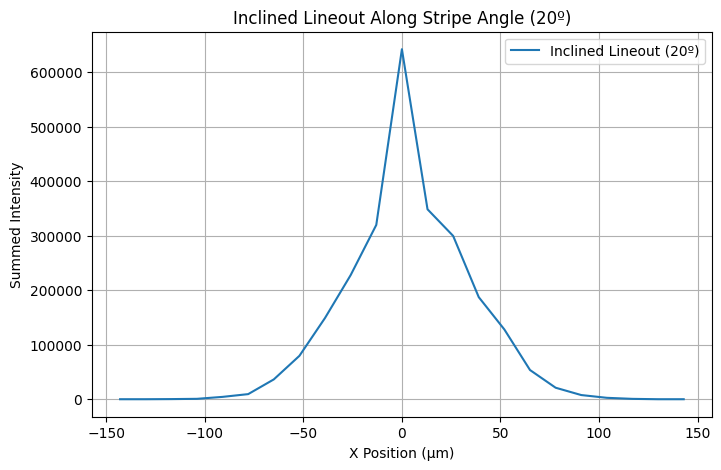

In [53]:
def compute_inclined_lineout(autocorr_avg, angle_deg=20, width=10):
    """
    Compute a lineout along an inclined direction at a given angle.
    
    Parameters:
      autocorr_avg: 2D autocorrelation image.
      angle_deg   : Angle of the stripes (in degrees, default 20º).
      width       : Number of pixels to average over perpendicular to the line.
    
    Returns:
      lineout_values: 1D array of extracted values along the inclined line.
      x_coords_um: Corresponding x-coordinates in microns.
    """

    # Convert angle to radians
    angle_rad = np.radians(angle_deg)

    # Get image dimensions
    Ny, Nx = autocorr_avg.shape

    # Define center of image
    center_x, center_y = Nx // 2, Ny // 2

    # Define range of x-values (line will pass through center)
    x_coords = np.arange(-Nx//2, Nx//2)  # Centered at 0
    y_coords = np.tan(angle_rad) * x_coords  # 20º inclined line

    # Convert to actual image indices
    x_indices = np.round(x_coords + center_x).astype(int)
    y_indices = np.round(y_coords + center_y).astype(int)

    # Ensure indices are within bounds before modifying them
    valid_mask = (x_indices >= 0) & (x_indices < Nx) & (y_indices >= 0) & (y_indices < Ny)

    # Apply valid_mask BEFORE the loop
    x_indices = x_indices[valid_mask]
    y_indices = y_indices[valid_mask]
    x_coords = x_coords[valid_mask]  # Keep only valid x-coordinates

    # Extract values along the line using interpolation
    lineout_values = map_coordinates(autocorr_avg, [y_indices, x_indices], order=1)

    # Average over a band of width=10 pixels around the inclined line
    summed_values = np.zeros_like(lineout_values)
    for offset in range(-width//2, width//2):
        y_offset = y_indices + offset
        valid_offset_mask = (y_offset >= 0) & (y_offset < Ny)
        summed_values[valid_offset_mask] += map_coordinates(
            autocorr_avg, [y_offset[valid_offset_mask], x_indices[valid_offset_mask]], order=1
        )

    # Convert x-coordinates to microns using detector scale
    detector_pixel_size_um = 13  # Each pixel is 13 µm
    x_coords_um = x_coords * detector_pixel_size_um  # Now this matches the valid indices

    return x_coords_um, summed_values

# ---------------------------------------------------
# Call the function inside your g² analysis script
# ---------------------------------------------------
x_coords_um, lineout = compute_inclined_lineout(autocorr_avg, angle_deg=angle, width=5)

# Plot the lineout
plt.figure(figsize=(8, 5))
plt.plot(x_coords_um, lineout, label="Inclined Lineout (20º)")
plt.xlabel("X Position (µm)")
plt.ylabel("Summed Intensity")
plt.title("Inclined Lineout Along Stripe Angle (20º)")
plt.legend()
plt.grid()
plt.show()

